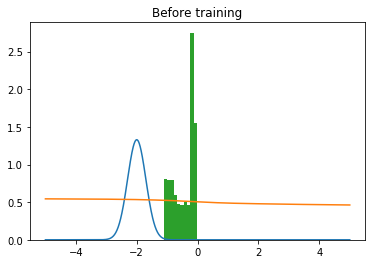

Discriminator loss 0.2921658456325531
Generator loss 0.7339916825294495

Discriminator loss 0.5383506417274475
Generator loss 0.6921868920326233

Discriminator loss 0.6300932168960571
Generator loss 0.4154317080974579

Discriminator loss 0.6525332927703857
Generator loss 0.4063433110713959

Discriminator loss 0.6932675838470459
Generator loss 0.3466266989707947

Discriminator loss 0.6895207762718201
Generator loss 0.35031282901763916

Discriminator loss 0.6887274980545044
Generator loss 0.3511495590209961

Discriminator loss 0.6848500967025757
Generator loss 0.3542575538158417

Discriminator loss 0.6818580627441406
Generator loss 0.3565445840358734

Discriminator loss 0.6797872185707092
Generator loss 0.3616686165332794

Discriminator loss 0.6755972504615784
Generator loss 0.36181774735450745

Discriminator loss 0.6738513112068176
Generator loss 0.367095947265625

Discriminator loss 0.6713845133781433
Generator loss 0.3668873906135559

Discriminator loss 0.6701569557189941
Generator lo

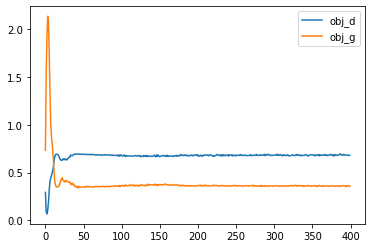

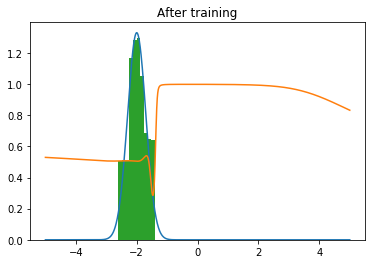

In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from scipy.stats import norm
import matplotlib.pyplot as plt


def sample_noise(M):
    z = np.float32(np.linspace(-5.0, 5.0, M) + np.random.random(M) * 0.01)
    return z


def plot_decision_boundary(discriminate):
    xs = np.linspace(-5, 5, 1000)
    plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')

    r = 1000
    xs = np.float32(np.linspace(-5, 5, r))
    xs_tensor = Variable(torch.from_numpy(xs.reshape(r, 1)))
    ds_tensor = discriminate(xs_tensor)
    ds = ds_tensor.data.numpy()
    plt.plot(xs, ds, label='decision boundary')
    plt.show()


def plot_fig(generate, discriminate):
    xs = np.linspace(-5, 5, 1000)
    plt.plot(xs, norm.pdf(xs, loc=mu, scale=sigma), label='p_data')

    r = 5000
    xs = np.float32(np.linspace(-5, 5, r))
    xs_tensor = Variable(torch.from_numpy(xs.reshape(r, 1)))
    ds_tensor = discriminate(xs_tensor)
    ds = ds_tensor.data.numpy()
    plt.plot(xs, ds, label='decision boundary')

    zs = sample_noise(r)
    zs_tensor = Variable(torch.from_numpy(np.float32(zs.reshape(r, 1))))
    gs_tensor = generate(zs_tensor)
    gs = gs_tensor.data.numpy()
    plt.hist(gs, bins=10, density=True)


# Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l1_relu = nn.ReLU()
        self.l2 = nn.Linear(10, 10)
        self.l2_relu = nn.ReLU()
        self.l3 = nn.Linear(10, 1)

    def forward(self, input):
        output = self.l1(input)
        output = self.l1_relu(output)
        output = self.l2(output)
        output = self.l2_relu(output)
        output = self.l3(output)
        return output


# Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.l1 = nn.Linear(1, 10)
        self.l1_tanh = nn.Tanh()
        self.l2 = nn.Linear(10, 10)
        self.l2_tanh = nn.Tanh()
        self.l3 = nn.Linear(10, 1)
        self.l3_sigmoid = nn.Sigmoid()

    def forward(self, input):
        output = self.l1_tanh(self.l1(input))
        output = self.l2_tanh(self.l2(output))
        output = self.l3_sigmoid(self.l3(output))
        return output


def generator_criterion(d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_g))


def discriminator_criterion(d_output_true, d_output_g):
    return -0.5 * torch.mean(torch.log(d_output_true) + torch.log(1 - d_output_g))


mu = -2
sigma = 0.3
M = 200

discriminate = Discriminator()
generate = Generator()

plot_fig(generate, discriminate)
plt.title('Before training')
plt.show()

epochs = 400
histd, histg = np.zeros(epochs), np.zeros(epochs)
k = 20

visualize_training = False

plt.ion()

discriminate_optimizer = torch.optim.SGD(discriminate.parameters(), lr=0.1, momentum=0.6)
generate_optimizer = torch.optim.SGD(generate.parameters(), lr=0.01, momentum=0.6)

for i in range(epochs):
    for j in range(k):
        discriminate.zero_grad()
        x = np.float32(np.random.normal(mu, sigma, M))
        z = sample_noise(M)
        z_tensor = Variable(torch.from_numpy(np.float32(z.reshape(M, 1))))
        x_tensor = Variable(torch.from_numpy(np.float32(x.reshape(M, 1))))
        g_out = generate(z_tensor)
        d_out_true = discriminate(x_tensor)
        d_out_g = discriminate(g_out)
        loss = discriminator_criterion(d_out_true, d_out_g)
        loss.backward()
        discriminate_optimizer.step()
        histd[i] = loss.data.numpy()

    generate.zero_grad()
    z = sample_noise(M)
    z_tensor = Variable(torch.from_numpy(np.float32(z.reshape(M, 1))))
    g_out = generate(z_tensor)
    d_out_g = discriminate(g_out)
    loss = generator_criterion(d_out_g)
    loss.backward()
    generate_optimizer.step()
    histg[i] = loss.data.numpy()

    if i % 10 == 0:
        print('Discriminator loss', histd[i])
        print('Generator loss', histg[i])
        print()
        for param_group in generate_optimizer.param_groups:
            param_group['lr'] *= 0.999
        for param_group in discriminate_optimizer.param_groups:
            param_group['lr'] *= 0.999

    if visualize_training:
        plt.clf()
        plot_fig(generate, discriminate)
        plt.draw()

plt.ioff()

plt.clf()
plt.plot(range(epochs), histd, label='obj_d')
plt.plot(range(epochs), histg, label='obj_g')
plt.legend()
plt.show()

plot_fig(generate, discriminate)
plt.title('After training')
plt.show()